In [1]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /home/andrey/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/andrey/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
# Preprocess the Data: from naivebayes2 (Melvin Adkins work)

lemmatizer = WordNetLemmatizer()

filepath = "finalized_8K_accounts.csv"
hand_label = "hand.label"
government = "gov"
academia = "acad"

df = pd.read_csv(filepath)

df = df[((df[hand_label]=='media') | (df[hand_label]== academia) | (df[hand_label]==government) | (df[hand_label]=='other' ))]


df = df[['username','description',hand_label]] # keep only relevant columns


# Preprocessing step - lemmatization on description column
words_not_changed = ['media']

def preprocessing(row):
    if str(row) == "nan":
        row = ""
    else:
        row = str(row).lower()          # lowercase (so that upper and lowercase words are treated the same)
        row = word_tokenize(row)        # tokenize  (to perform lemmitization)
        row = [lemmatizer.lemmatize(word) if word not in words_not_changed else word for word in row]   # lemmatize
    return str(row)                     # convert back to string


df['description_lemmatized'] = df['description'].apply(preprocessing)


print(df.head())
print()

print(df.head())
print()
print('Number of labels per category:')
print(df[hand_label].value_counts())
print()

       username                                        description hand.label  \
0   Casper30214  Army Civil Service(Retired);Military Ops Resea...      other   
1         enckj  Former EPA Regional Administrator, President o...       acad   
2  nuclearkelly  Scientist at ORNL, DOE Early Career Awardee, F...       acad   
3       stukhan  Dad. Director of the Australian Graduate Schoo...       acad   
4       PatMag7  Podcasting about Feminist Participatory Action...       acad   

                              description_lemmatized  
0  ['army', 'civil', 'service', '(', 'retired', '...  
1  ['former', 'epa', 'regional', 'administrator',...  
2  ['scientist', 'at', 'ornl', ',', 'doe', 'early...  
3  ['dad', '.', 'director', 'of', 'the', 'austral...  
4  ['podcasting', 'about', 'feminist', 'participa...  

       username                                        description hand.label  \
0   Casper30214  Army Civil Service(Retired);Military Ops Resea...      other   
1         enckj  For

In [3]:
# split my data into training, and test sets
scaler = StandardScaler(with_mean = False)

X = df['description_lemmatized']
y_labels = df[hand_label]

X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

ValueError: could not convert string to float: "['reporter', 'for', '@', 'tblightning', '+', '@', 'ballysportsfl']"

In [8]:
#print("SHAPE:", X_train.shape)

SHAPE: (6281,)


In [153]:
#print(X.value_counts())


                                                                                                                                                                                                                                                         1357
['teacher']                                                                                                                                                                                                                                                 3
['.']                                                                                                                                                                                                                                                       3
['she/her']                                                                                                                                                                                                                                   

In [9]:
#print(X_train.value_counts())

description_lemmatized
                                                                                                                                                                                                                                                                                1092
['.']                                                                                                                                                                                                                                                                              3
['she/her']                                                                                                                                                                                                                                                                        3
['teacher']                                                                                                                                       

In [10]:
#print(y_train.value_counts())

hand.label
other    5785
media     317
acad      150
gov        29
Name: count, dtype: int64


In [11]:
#print(y_test.value_counts())

hand.label
other    1447
media      80
acad       37
gov         7
Name: count, dtype: int64


In [12]:
#nan_counts = X_train.isna().sum()
#print(nan_counts)

0


In [13]:
#nan_counts = y_train.isna().sum()
#print(nan_counts)

0


In [20]:
tfidf_transformer = TfidfTransformer()
count_vectorizer = CountVectorizer(stop_words="english")


tfidf_pipeline = Pipeline([
    ('vectorizer', count_vectorizer),
    ('transformer', tfidf_transformer),
    ('normalize', StandardScaler(with_mean=False)),
    ('classifier', SVC())
])

tfidf_param_grid = [
    {
        'vectorizer__min_df': [0.0, 0.01, 0.015, 0.02], # 
        'transformer__use_idf': [True], # 'transformer__use_idf': [True, False],
        'classifier__C': [1.0e-10, 0.5, 3.0, 10.0], #'classifier__C': [1.0e-10, 0.5, 2.0, 5.0, 10.0],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__class_weight': ["balanced"]
    }
]

In [21]:
count_vectorizer = CountVectorizer(stop_words="english")

bag_of_words_pipeline = Pipeline([
    ('vectorizer', count_vectorizer),
    ('normalize', StandardScaler(with_mean=False)),
    ('classifier', SVC())
])

bag_of_words_param_grid = [
    {
        'vectorizer__min_df': [0.0, 0.01, 0.015, 0.02], #     
        'classifier__C': [1.0e-10, 0.5, 3.0, 10.0], #'classifier__C': [1.0e-10, 0.5, 2.0, 5.0, 10.0],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__class_weight': ["balanced"]
    }
]


In [22]:
# Grid Search - TF-IDF
tfidf_grid_search = GridSearchCV(estimator=tfidf_pipeline, param_grid=tfidf_param_grid, cv=5, scoring='accuracy', verbose=10, error_score="raise")

tfidf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5; 1/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.0
[CV 1/5; 1/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.024 total time=  13.7s
[CV 2/5; 1/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.0
[CV 2/5; 1/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.024 total time=  11.5s
[CV 3/5; 1/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.0
[CV 3/5; 1/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, tran

[CV 5/5; 5/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.005 total time=   5.8s
[CV 1/5; 6/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.01
[CV 1/5; 6/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.024 total time=   2.7s
[CV 2/5; 6/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.01
[CV 2/5; 6/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.024 total time=   2.3s
[CV 3/5; 6/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__mi

[CV 5/5; 10/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.005 total time=   2.7s
[CV 1/5; 11/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.015
[CV 1/5; 11/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.024 total time=   2.6s
[CV 2/5; 11/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.015
[CV 2/5; 11/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.024 total time=   2.8s
[CV 3/5; 11/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorize

[CV 4/5; 15/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.005 total time=   2.0s
[CV 5/5; 15/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.015
[CV 5/5; 15/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.005 total time=   1.8s
[CV 1/5; 16/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.02
[CV 1/5; 16/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.024 total time=   1.6s
[CV 2/5; 16/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__

[CV 4/5; 20/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.738 total time=   2.4s
[CV 5/5; 20/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.02
[CV 5/5; 20/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.739 total time=   2.9s
[CV 1/5; 21/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.0
[CV 1/5; 21/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.920 total time=   5.3s
[CV 2/5; 21/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min

[CV 4/5; 25/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.928 total time=   5.2s
[CV 5/5; 25/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.0
[CV 5/5; 25/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.931 total time=   5.0s
[CV 1/5; 26/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.01
[CV 1/5; 26/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.821 total time=   1.4s
[CV 2/5; 26/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.01
[CV 

[CV 4/5; 30/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.662 total time=   1.4s
[CV 5/5; 30/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.01
[CV 5/5; 30/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.646 total time=   1.4s
[CV 1/5; 31/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.015
[CV 1/5; 31/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.617 total time=   1.8s
[CV 2/5; 31/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True,

[CV 4/5; 35/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.244 total time=  11.3s
[CV 5/5; 35/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.015
[CV 5/5; 35/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.690 total time=  17.5s
[CV 1/5; 36/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.02
[CV 1/5; 36/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.726 total time=   3.9s
[CV 2/5; 36/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vect

[CV 4/5; 40/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.773 total time=   1.1s
[CV 5/5; 40/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.02
[CV 5/5; 40/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.763 total time=   1.1s
[CV 1/5; 41/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.0
[CV 1/5; 41/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.928 total time=   5.1s
[CV 2/5; 41/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.0
[

[CV 4/5; 45/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.932 total time=   1.8s
[CV 5/5; 45/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.0
[CV 5/5; 45/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.939 total time=   1.9s
[CV 1/5; 46/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.01
[CV 1/5; 46/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.552 total time=   1.3s
[CV 2/5; 46/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vect

[CV 4/5; 50/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.686 total time= 1.2min
[CV 5/5; 50/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.01
[CV 5/5; 50/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.01;, score=0.699 total time= 1.6min
[CV 1/5; 51/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.015
[CV 1/5; 51/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.696 total time=  53.2s
[CV 2/5; 51/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=linear, transformer__use_idf=True,

[CV 4/5; 55/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.333 total time=   1.2s
[CV 5/5; 55/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.015
[CV 5/5; 55/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.015;, score=0.766 total time=   1.1s
[CV 1/5; 56/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.02
[CV 1/5; 56/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.748 total time=   1.1s
[CV 2/5; 56/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, transformer__use_idf=True, vectorizer

[CV 4/5; 60/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.782 total time=   1.4s
[CV 5/5; 60/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.02
[CV 5/5; 60/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, transformer__use_idf=True, vectorizer__min_df=0.02;, score=0.769 total time=   1.4s
[CV 1/5; 61/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.0
[CV 1/5; 61/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorizer__min_df=0.0;, score=0.934 total time=   1.6s
[CV 2/5; 61/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, transformer__use_idf=True, vectorize

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('transformer', TfidfTransformer()),
                                       ('normalize',
                                        StandardScaler(with_mean=False)),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier__C': [1e-10, 0.5, 3.0, 10.0],
                          'classifier__class_weight': ['balanced'],
                          'classifier__kernel': ['linear', 'poly', 'rbf',
                                                 'sigmoid'],
                          'transformer__use_idf': [True],
                          'vectorizer__min_df': [0.0, 0.01, 0.015, 0.02]}],
             scoring='accuracy', verbose=10)

In [23]:
# Bag Of Words
bag_of_words_grid_search = GridSearchCV(estimator=bag_of_words_pipeline, param_grid=bag_of_words_param_grid, cv=5, scoring='accuracy', verbose=10,error_score="raise" )

bag_of_words_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5; 1/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.0
[CV 1/5; 1/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.0;, score=0.024 total time=   4.2s
[CV 2/5; 1/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.0
[CV 2/5; 1/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.0;, score=0.024 total time=   4.8s
[CV 3/5; 1/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.0
[CV 3/5; 1/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.0;, score=0.005 total time=   4.3s
[CV 4/5; 1/64] START classifier__C=1e-10, classifier__class_weight=balanced, classi

[CV 5/5; 6/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.01;, score=0.005 total time=   2.1s
[CV 1/5; 7/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.015
[CV 1/5; 7/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.015;, score=0.024 total time=   1.8s
[CV 2/5; 7/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.015
[CV 2/5; 7/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.015;, score=0.024 total time=   1.7s
[CV 3/5; 7/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.015
[CV 3/5; 7/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.015;, score=0.005 total t

[CV 4/5; 12/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.02;, score=0.005 total time=   2.4s
[CV 5/5; 12/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.02
[CV 5/5; 12/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.02;, score=0.005 total time=   2.4s
[CV 1/5; 13/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.0
[CV 1/5; 13/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.0;, score=0.024 total time=   5.2s
[CV 2/5; 13/64] START classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.0
[CV 2/5; 13/64] END classifier__C=1e-10, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.0;, score=0.024 t

[CV 3/5; 18/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.01;, score=0.683 total time=   4.0s
[CV 4/5; 18/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.01
[CV 4/5; 18/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.01;, score=0.702 total time=   3.1s
[CV 5/5; 18/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.01
[CV 5/5; 18/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.01;, score=0.746 total time=   5.5s
[CV 1/5; 19/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.015
[CV 1/5; 19/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.015;, score=0.722 tota

[CV 2/5; 24/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.02;, score=0.782 total time=   1.2s
[CV 3/5; 24/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.02
[CV 3/5; 24/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.02;, score=0.790 total time=   1.2s
[CV 4/5; 24/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.02
[CV 4/5; 24/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.02;, score=0.824 total time=   1.2s
[CV 5/5; 24/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.02
[CV 5/5; 24/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.02;, score=0.845 total time=   1.2s
[

[CV 2/5; 30/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.01;, score=0.623 total time=   1.6s
[CV 3/5; 30/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.01
[CV 3/5; 30/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.01;, score=0.605 total time=   1.4s
[CV 4/5; 30/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.01
[CV 4/5; 30/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.01;, score=0.646 total time=   1.6s
[CV 5/5; 30/64] START classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.01
[CV 5/5; 30/64] END classifier__C=0.5, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.01;, score=0.635

[CV 1/5; 36/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.02;, score=0.754 total time=   3.1s
[CV 2/5; 36/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.02
[CV 2/5; 36/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.02;, score=0.737 total time=   2.6s
[CV 3/5; 36/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.02
[CV 3/5; 36/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.02;, score=0.738 total time=   2.7s
[CV 4/5; 36/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.02
[CV 4/5; 36/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=linear, vectorizer__min_df=0.02;, score=0.760 total 

[CV 1/5; 42/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.01;, score=0.814 total time=   1.2s
[CV 2/5; 42/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.01
[CV 2/5; 42/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.01;, score=0.792 total time=   1.1s
[CV 3/5; 42/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.01
[CV 3/5; 42/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.01;, score=0.811 total time=   1.0s
[CV 4/5; 42/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.01
[CV 4/5; 42/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.01;, score=0.827 total time=   1.0s
[CV 5/5;

[CV 5/5; 47/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.015;, score=0.623 total time=   1.2s
[CV 1/5; 48/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.02
[CV 1/5; 48/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.02;, score=0.632 total time=   1.2s
[CV 2/5; 48/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.02
[CV 2/5; 48/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.02;, score=0.644 total time=   1.2s
[CV 3/5; 48/64] START classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.02
[CV 3/5; 48/64] END classifier__C=3.0, classifier__class_weight=balanced, classifier__kernel=sigmoid, vectorizer__min_df=0.02;, score=0.66

[CV 4/5; 53/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.0;, score=0.921 total time=   1.8s
[CV 5/5; 53/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.0
[CV 5/5; 53/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.0;, score=0.920 total time=   2.1s
[CV 1/5; 54/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.01
[CV 1/5; 54/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.01;, score=0.783 total time=   0.9s
[CV 2/5; 54/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.01
[CV 2/5; 54/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=poly, vectorizer__min_df=0.01;, score=0.761 total time=   1.

[CV 4/5; 59/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.015;, score=0.341 total time=   1.4s
[CV 5/5; 59/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.015
[CV 5/5; 59/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.015;, score=0.782 total time=   1.3s
[CV 1/5; 60/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.02
[CV 1/5; 60/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.02;, score=0.762 total time=   1.3s
[CV 2/5; 60/64] START classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.02
[CV 2/5; 60/64] END classifier__C=10.0, classifier__class_weight=balanced, classifier__kernel=rbf, vectorizer__min_df=0.02;, score=0.747 total time=   1.4

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('normalize',
                                        StandardScaler(with_mean=False)),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier__C': [1e-10, 0.5, 3.0, 10.0],
                          'classifier__class_weight': ['balanced'],
                          'classifier__kernel': ['linear', 'poly', 'rbf',
                                                 'sigmoid'],
                          'vectorizer__min_df': [0.0, 0.01, 0.015, 0.02]}],
             scoring='accuracy', verbose=10)

In [24]:
tfidf_best_hyperparameters = tfidf_grid_search.best_params_
print("Best TF-IDF SVM ACCURACY:", tfidf_grid_search.best_score_)
print("Best TF-IDF SVM Hyperparameters:", tfidf_best_hyperparameters)

print()

Best TF-IDF SVM ACCURACY: 0.9430024981124809
Best TF-IDF SVM Hyperparameters: {'classifier__C': 0.5, 'classifier__class_weight': 'balanced', 'classifier__kernel': 'linear', 'transformer__use_idf': True, 'vectorizer__min_df': 0.0}



In [25]:
bag_of_words_best_hyperparameters = bag_of_words_grid_search.best_params_
print("Best Bag of Words ACCURACY:", bag_of_words_grid_search.best_score_)
print("Best Bag of Words Hyperparameters:", bag_of_words_best_hyperparameters)

print()

Best TF-IDF Bag of Words ACCURACY: 0.9410917967661352
Best TF-IDF Bag of Words Hyperparameters: {'classifier__C': 0.5, 'classifier__class_weight': 'balanced', 'classifier__kernel': 'sigmoid', 'vectorizer__min_df': 0.0}



In [165]:
# print(tfidf_grid_search.cv_results_)

In [26]:
tfidf_best_SVM_model = tfidf_grid_search.best_estimator_

In [27]:
bag_of_words_best_SVM_model = bag_of_words_grid_search.best_estimator_

In [28]:
tfidf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('transformer', TfidfTransformer()),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier', SVC())])

In [29]:
bag_of_words_pipeline.set_params(**bag_of_words_grid_search.best_params_)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=0.0, stop_words='english')),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier',
                 SVC(C=0.5, class_weight='balanced', kernel='sigmoid'))])

In [30]:
tfidf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', CountVectorizer(stop_words='english')),
                ('transformer', TfidfTransformer()),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier', SVC())])

In [31]:
bag_of_words_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=0.0, stop_words='english')),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier',
                 SVC(C=0.5, class_weight='balanced', kernel='sigmoid'))])

In [32]:
# Cross validate
y_pred_tfidf = cross_val_predict(tfidf_best_SVM_model, X_train, y_train, cv=5)

In [33]:
y_pred_bag_of_words = cross_val_predict(bag_of_words_best_SVM_model, X_train, y_train, cv=5)


In [4]:
cm = confusion_matrix(y_train, y_pred_tfidf, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['academia', 'government', 'media', 'other'])
disp.plot()

plt.title("TF-IDF Train")
plt.show()

NameError: name 'y_pred_tfidf' is not defined

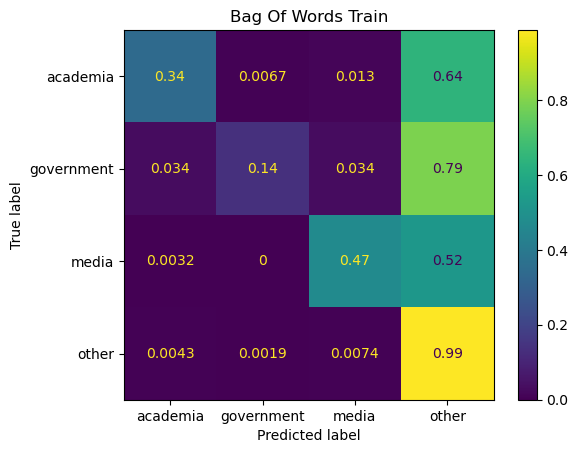

In [35]:
cm = confusion_matrix(y_train, y_pred_bag_of_words, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['academia', 'government', 'media', 'other'])
disp.plot()

plt.title("Bag Of Words Train")
plt.show()

In [36]:
print("TF-IDF Classification Report:")
print(metrics.classification_report(y_train, y_pred_tfidf))

TF-IDF Classification Report:
              precision    recall  f1-score   support

        acad       0.72      0.26      0.38       150
         gov       0.36      0.14      0.20        29
       media       0.82      0.47      0.60       317
       other       0.95      0.99      0.97      5785

    accuracy                           0.94      6281
   macro avg       0.71      0.47      0.54      6281
weighted avg       0.93      0.94      0.93      6281



In [37]:
print("Bag of Words Classification Report:")
print(metrics.classification_report(y_train, y_pred_bag_of_words))

Bag of Words Classification Report:
              precision    recall  f1-score   support

        acad       0.65      0.34      0.45       150
         gov       0.25      0.14      0.18        29
       media       0.77      0.47      0.58       317
       other       0.95      0.99      0.97      5785

    accuracy                           0.94      6281
   macro avg       0.66      0.48      0.54      6281
weighted avg       0.93      0.94      0.93      6281



In [42]:
tfidf_y_pred_test = tfidf_pipeline.predict(tfidf_pipeline.normalize(X_test))

tfidf_pipeline.StandardScaler()

AttributeError: 'Pipeline' object has no attribute 'normalize'

In [54]:
#StandardScaler(with_mean=False).fit(X_test)

# use fit() and transform separately
std_slc = StandardScaler()
X_train.CountVectorizer(stop_words="english")
std_slc.fit(CountVectorizer(X_train, stop_words="english"))
X_train_std = std_slc.transform(CountVectorizer(X_train, stop_words="english"))
X_test_std = std_slc.transform(CountVectorizer(X_test, stop_words="english"))


print('Transformed Train: \n', X_train_std[0:5])
print('Transformed Test: \n', X_test_std[0:5])

AttributeError: 'Series' object has no attribute 'CountVectorizer'

In [39]:
bag_of_words_y_pred_test = bag_of_words_pipeline.predict(X_test)

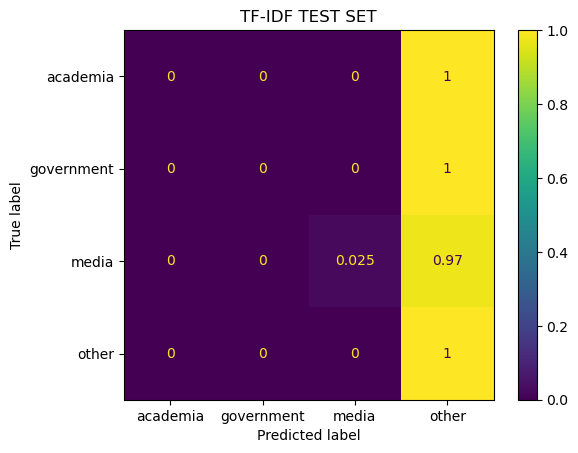

In [40]:
cm = confusion_matrix(y_test, tfidf_y_pred_test, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['academia', 'government', 'media', 'other'])
disp.plot()

plt.title("TF-IDF TEST SET")
plt.show()

In [49]:
tfidf_y_pred_test

array(['other', 'other', 'other', ..., 'other', 'other', 'other'],
      dtype=object)

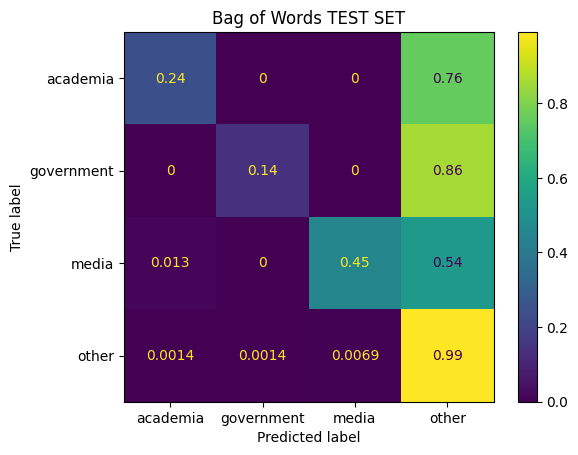

In [181]:
cm = confusion_matrix(y_test, bag_of_words_y_pred_test, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['academia', 'government', 'media', 'other'])
disp.plot()

plt.title("Bag of Words TEST SET")
plt.show()

In [182]:
print("TF-IDF Classification Report TEST:")
print(metrics.classification_report(y_test, tfidf_y_pred_test))
print()

TF-IDF Classification Report TEST:
              precision    recall  f1-score   support

        acad       0.00      0.00      0.00        37
         gov       0.00      0.00      0.00         7
       media       1.00      0.03      0.05        80
       other       0.92      1.00      0.96      1447

    accuracy                           0.92      1571
   macro avg       0.48      0.26      0.25      1571
weighted avg       0.90      0.92      0.89      1571




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [183]:
print("Bag of Words Classification Report TEST:")
print(metrics.classification_report(y_test, bag_of_words_y_pred_test))
print()

Bag of Words Classification Report TEST:
              precision    recall  f1-score   support

        acad       0.75      0.24      0.37        37
         gov       0.33      0.14      0.20         7
       media       0.78      0.45      0.57        80
       other       0.95      0.99      0.97      1447

    accuracy                           0.94      1571
   macro avg       0.70      0.46      0.53      1571
weighted avg       0.93      0.94      0.93      1571


